#**ML PRACTICAL EXAMINATION**
---

#**Emotion Detection from Text using ML**

---


**Group Members:**
*   Sunit Trivedi
*   Nehaal Pandey
*   Divyansh Sawant
    
**Division : A**
    
**Batch : ML2**



---

## About Dataset

The dataset being used is the **sentiment140 dataset**. 

It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.
 

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*



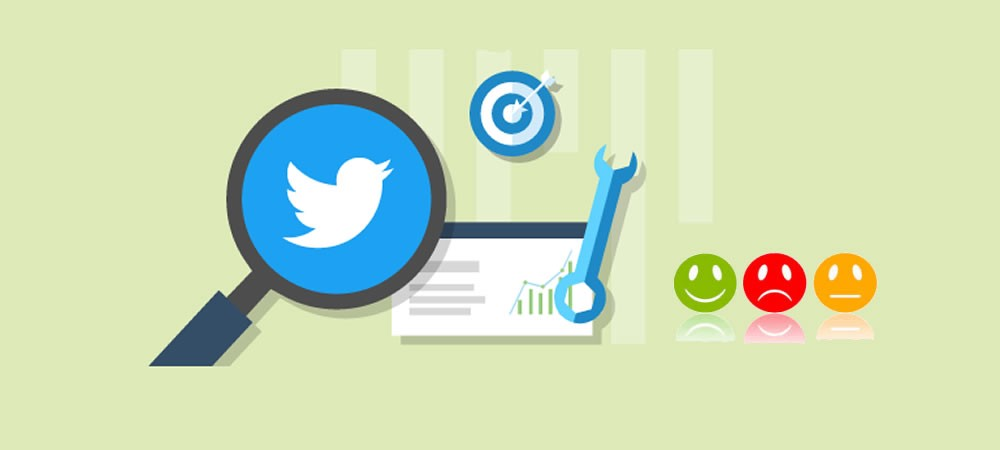

## Importing dependencies

In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle

# plotting
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, f1_score, recall_score
from mlxtend.plotting import plot_confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Importing dataset




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(r'/content/drive/MyDrive/ML_lab/training_600000_processed_noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
dataset.shape

(1600000, 6)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
dataset.head(4)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire


In [ ]:
dataset.describe()

,sentiment,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


## Data Cleaning

In [ ]:
# Total number of missing values and percent of it.
total = dataset.isnull().sum().sort_values(ascending = False)
percent = (dataset.isnull().sum()/dataset.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
sentiment,0,0.0
ids,0,0.0
date,0,0.0
flag,0,0.0
user,0,0.0
text,0,0.0


In [ ]:
# mapping sentiment data to classes 0 and 4 and convert 4 to 1 to be more intutive
datatset = pd.concat([dataset.query("sentiment==0"), dataset.query("sentiment==4")])
dataset.sentiment = dataset.sentiment.map({0:0, 4:1})
dataset =  shuffle(dataset).reset_index(drop=True)

##Exploratory Data Analysis

<Axes: title={'center': 'Distribution of data'}>

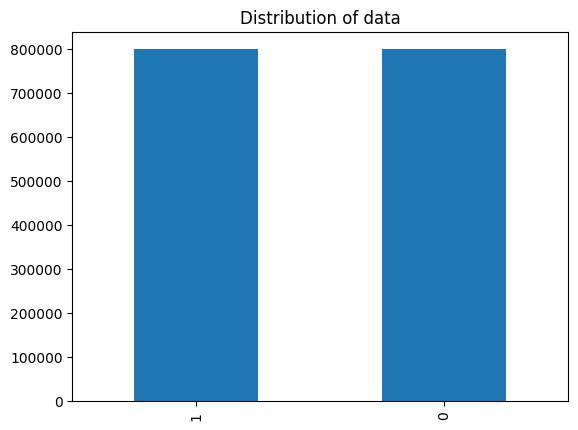

In [ ]:
# Plotting the distribution for dataset.
x = dataset.sentiment.value_counts()
x.plot(kind='bar', title='Distribution of data', legend=False)

# There are only two classes 0(negative) and 1(positive).

In [ ]:
# Commonly occuring words and stop words in dataset
corpus = []

word = dataset['text'].str.split()
new = word.values.tolist()
corpus=[word for i in new for word in i]

Text(0.5, 1.0, 'Commonly occuring words')

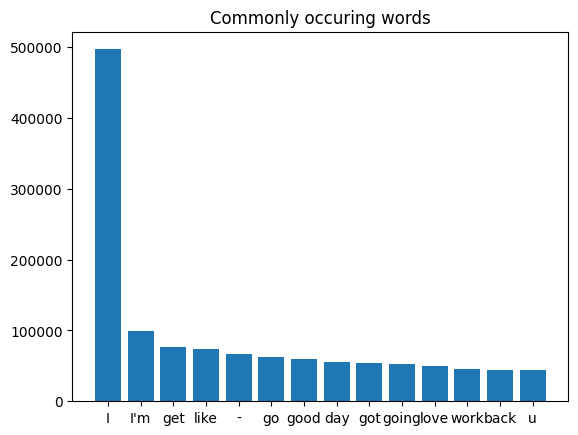

In [ ]:
from collections import Counter

counter=Counter(corpus)
most=counter.most_common(100)

x, y= [], []
for word,count in most[:50]:
    # can avoid stop words too
    if word not in stop:
        x.append(word)
        y.append(count)
        
plt.bar(x,y)
plt.title('Commonly occuring words')

In [ ]:
temp = pd.DataFrame(most)
fig = px.treemap(temp, path=[0], values=1,title='Tree of Most Common Tweeted words')
fig.show()

Text(0.5, 1.0, 'Commonly occuring stop words')

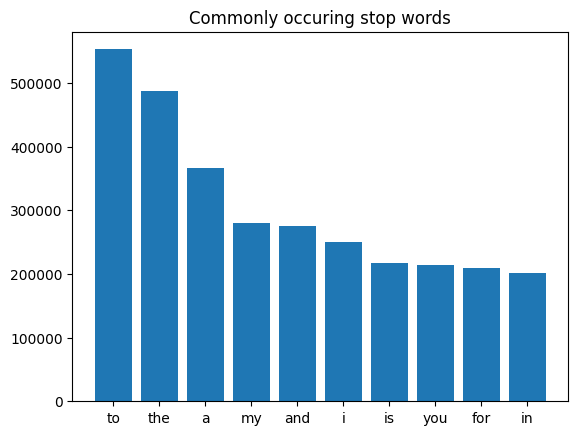

In [ ]:
from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)
plt.title('Commonly occuring stop words')

In [ ]:
temp = pd.DataFrame(top)
fig = px.treemap(temp, path=[0], values=1,title='Tree of Most Common Tweeted words in stop word list')
fig.show()

Text(0.5, 1.0, 'Length of tweets')

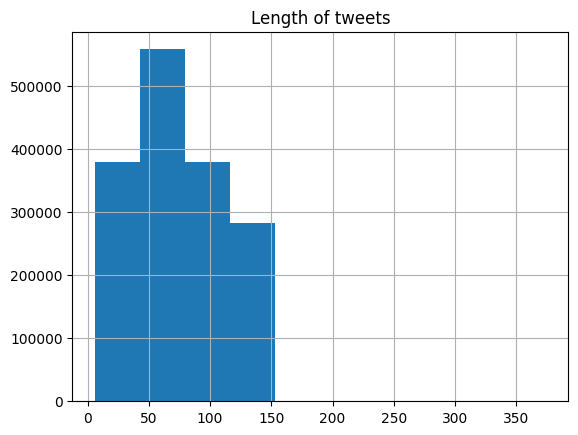

In [ ]:
# Analysing the word level data

# Length of tweets
dataset['text'].str.len().hist()
plt.title('Length of tweets')

Text(0.5, 1.0, 'length of words')

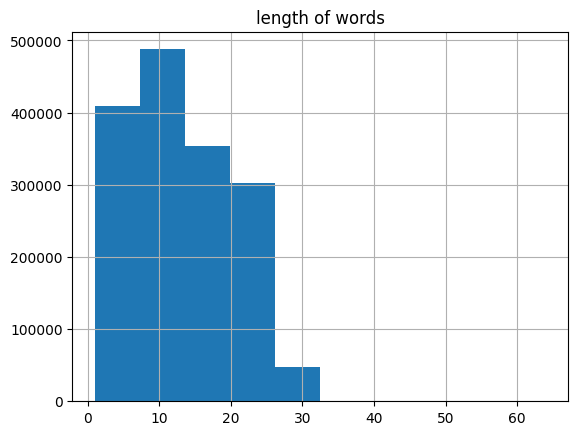

In [ ]:
# Range of length of words
dataset['text'].str.split().map(lambda x: len(x)).hist()
plt.title('length of words')

In [ ]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## Preprocess Text
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)

        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])       

        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  

        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)

        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 151 seconds


## Analysing the data
Plot **Word Clouds** for **Positive and Negative** tweets from dataset

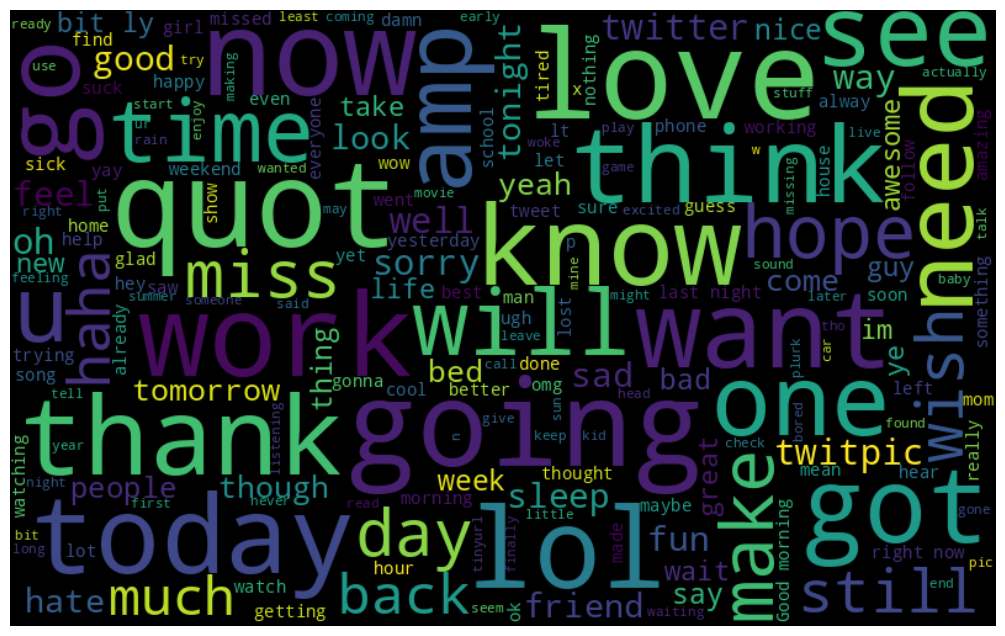

In [ ]:
# visualize the frequent words

all_words = " ".join([sentence for sentence in dataset['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word-Cloud for Negative tweets.

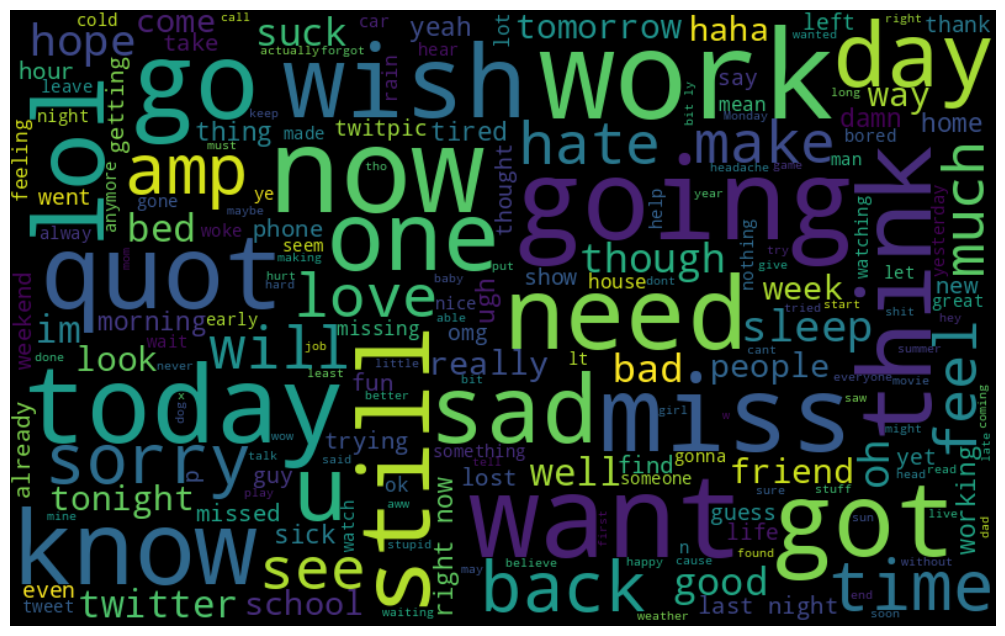

In [ ]:
# frequent words visualization for -ve

all_words = " ".join([sentence for sentence in dataset['text'][dataset['sentiment']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word-Cloud for Positive tweets.

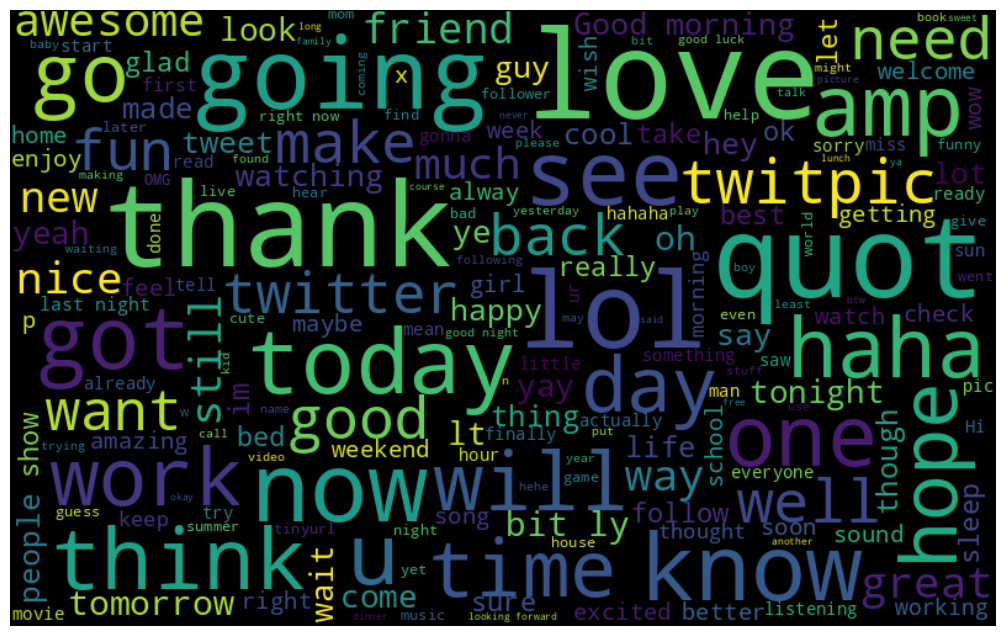

In [ ]:
# frequent words visualization for +ve

all_words = " ".join([sentence for sentence in dataset['text'][dataset['sentiment']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Model Building

### Splitting the Data
The Preprocessed Data is divided into 2 sets of data: 
* **Training Data:** The dataset upon which the model would be trained on. Contains 95% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 5% data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


### TF-IDF Vectoriser
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** 

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset. 

**ngram_range**  is the range of number of words in a sequence. e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)

**max_features** specifies the number of features to consider.

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


### Tranforming the dataset
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. This datasets will be used to train the model and test against it.

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


### Logistic Regression

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred0 = LRmodel.predict(X_test)

# accuracy score, confusion matrix and classification report of LR

LR_acc = accuracy_score(y_test, LRmodel.predict(X_test))

print(f"Training Accuracy of LR is {accuracy_score(y_train, LRmodel.predict(X_train))*100}",'%')
print(f"Test Accuracy of LR is {(LR_acc*100)}",'%' "\n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, LRmodel.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, LRmodel.predict(X_test))}")

Training Accuracy of LR is 86.90092105263157 %
Test Accuracy of LR is 82.61749999999999 %

Confusion Matrix :- 
[[32649  7241]
 [ 6665 33445]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.83      0.82      0.82     39890
           1       0.82      0.83      0.83     40110

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



###Support Vector Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, f1_score, recall_score

svmc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
svmc.fit(X_train, y_train)
y_pred1 = svmc.predict(X_test)

# accuracy score, confusion matrix and classification report of knn

svm_acc = accuracy_score(y_test, svmc.predict(X_test))

print(f"Training Accuracy of SVC is {accuracy_score(y_train, svmc.predict(X_train))*100}",'%')
print(f"Test Accuracy of SVC is {(svm_acc*100)}",'%' "\n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, svmc.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, svmc.predict(X_test))}")

Training Accuracy of SVC is 100.0 %
Test Accuracy of SVC is 60.0 %

Confusion Matrix :- 
[[72  0]
 [48  0]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.60      1.00      0.75        72
           1       0.00      0.00      0.00        48

    accuracy                           0.60       120
   macro avg       0.30      0.50      0.37       120
weighted avg       0.36      0.60      0.45       120



### Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB(alpha=0, force_alpha='warn', fit_prior=False, class_prior=None)
naive_bayes.fit(X_train,y_train)
y_pred3 = naive_bayes.predict(X_test)

# accuracy score, confusion matrix and classification report of Naive Bayes

nb_acc = accuracy_score(y_test, naive_bayes.predict(X_test))

print(f"Training Accuracy of Naive Bayes is {accuracy_score(y_train, naive_bayes.predict(X_train))*100}",'%')
print(f"Test Accuracy of Naive Bayes is {(nb_acc*100)}",'%' "\n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, naive_bayes.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, naive_bayes.predict(X_test))}")

Training Accuracy of Naive Bayes is 92.5 %
Test Accuracy of Naive Bayes is 94.16666666666667 %

Confusion Matrix :- 
[[67  5]
 [ 2 46]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        72
           1       0.90      0.96      0.93        48

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120



### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred4 = dtc.predict(X_test)

# accuracy score, confusion matrix and classification report of decision tree

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))

print(f"Training Accuracy of Decision Tree Classifier is {accuracy_score(y_train, dtc.predict(X_train))*100}",'%')
print(f"Test Accuracy of Decision Tree Classifier is {(dtc_acc*100)}",'%' "\n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, dtc.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, dtc.predict(X_test))}")

Training Accuracy of Decision Tree Classifier is 100.0 %
Test Accuracy of Decision Tree Classifier is 98.33333333333333 %

Confusion Matrix :- 
[[71  1]
 [ 1 47]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        48

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [ ]:
# hyper parameter tuning of decision tree 

from sklearn.model_selection import GridSearchCV
grid_param = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 10],
    'splitter' : ['best', 'random'],
    'min_samples_leaf' : [1, 2, 3, 5, 7],
    'min_samples_split' : [1, 2, 3, 5, 7],
    'max_features' : ['auto', 'sqrt', 'log2']
}

grid_search_dtc = GridSearchCV(dtc, grid_param, cv = 5, n_jobs = -1, verbose = 1)
grid_search_dtc.fit(X_train, y_train)
y_pred5 = grid_search_dtc.predict(X_test)


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [ ]:
print(grid_search_dtc.best_params_)
print(grid_search_dtc.best_score_)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
0.9821428571428571


In [ ]:
# best estimator

dtc = grid_search_dtc.best_estimator_

# accuracy score, confusion matrix and classification report of decision tree

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))

print(f"Training Accuracy of Decision Tree Classifier is {accuracy_score(y_train, dtc.predict(X_train))*100}",'%')
print(f"Test Accuracy of Decision Tree Classifier is {(dtc_acc*100)}",'%' "\n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, dtc.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, dtc.predict(X_test))}")

Training Accuracy of Decision Tree Classifier is 100.0 %
Test Accuracy of Decision Tree Classifier is 92.5 %

Confusion Matrix :- 
[[67  5]
 [ 4 44]]

Classification Report :- 
               precision    recall  f1-score   support

           0       0.94      0.93      0.94        72
           1       0.90      0.92      0.91        48

    accuracy                           0.93       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.93      0.93      0.93       120



### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rd_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 11, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 3, n_estimators = 130)
rd_clf.fit(X_train, y_train)
y_pred6 = rd_clf.predict(X_test)


# accuracy score, confusion matrix and classification report of random forest

rd_clf_acc = accuracy_score(y_test, rd_clf.predict(X_test))

print(f"Training Accuracy of Random Forest Classifier is {accuracy_score(y_train, rd_clf.predict(X_train))*100}",'%')
print(f"Test Accuracy of Random Forest Classifier is {(rd_clf_acc*100)}",'%' "\n")

print(f"Confusion Matrix :- \n{confusion_matrix(y_test, rd_clf.predict(X_test))}\n")
print(f"Classification Report :- \n {classification_report(y_test, rd_clf.predict(X_test))}")

Training Accuracy of Random Forest Classifier is 100.0 %
Test Accuracy of Random Forest Classifier is 100.0 %

Confusion Matrix :- 
[[72  0]
 [ 0 48]]

Classification Report :- 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        48

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



### Ensemble Classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier

dtc = DecisionTreeClassifier()
base_model = DecisionTreeClassifier(random_state=1)

bgc=BaggingClassifier(base_estimator=base_model,n_estimators=10, random_state=1)
bgc.fit(X_train,y_train)                                                 
y_pred10 = bgc.predict(X_test)
print(f"Accuracy: ",accuracy_score(y_test, y_pred10)*100,'%')
print(classification_report(y_test, y_pred10))

Accuracy:  100.0 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        48

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



## Models Comparison

In [ ]:
Model_Comparison = pd.DataFrame({'SVC':[accuracy_score(y_test,y_pred1)*100,f1_score(y_test,y_pred1,average='macro')*100,recall_score(y_test, y_pred1,average='micro')*100,precision_score(y_test, y_pred1,average='micro')*100],
                           'Naive Bayes':[accuracy_score(y_test,y_pred3)*100,f1_score(y_test,y_pred3,average='macro')*100,recall_score(y_test, y_pred3,average='micro')*100,precision_score(y_test, y_pred3,average='micro')*100],
                           'Decision Tree Classifier':[accuracy_score(y_test,y_pred4)*100,f1_score(y_test,y_pred4,average='macro')*100,recall_score(y_test, y_pred4,average='micro')*100,precision_score(y_test, y_pred4,average='micro')*100],
                           'Random Forest Classifier':[accuracy_score(y_test,y_pred6)*100,f1_score(y_test,y_pred6,average='macro')*100,recall_score(y_test, y_pred6,average='micro')*100,precision_score(y_test, y_pred6,average='micro')*100],
                           'Ensemble Classifier':[accuracy_score(y_test,y_pred10)*100,f1_score(y_test,y_pred10,average='macro')*100,recall_score(y_test, y_pred10,average='micro')*100,precision_score(y_test, y_pred10,average='micro')*100],
                           
})

In [ ]:
print ('Model Comparison') 
Model_Comparison.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Model_Comparison.head()

Model Comparison


,SVC,Naive Bayes,Decision Tree Classifier,Random Forest Classifier,Ensemble Classifier
Accuracy,60.0,94.166667,98.333333,100.0,100.0
F1_score,37.5,93.982377,98.263889,100.0,100.0
Recall,60.0,94.166667,98.333333,100.0,100.0
Precision,60.0,94.166667,98.333333,100.0,100.0


In [ ]:
models = pd.DataFrame({
    'Model' : [ 'SVC', 'Naive Bayes', 'Decision Tree Classifier', 'Random Forest Classifier'],
    'Score' : [svm_acc,nb_acc, dtc_acc, rd_clf_acc]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Random Forest Classifier,1.000000
2,Decision Tree Classifier,0.983333
1,Naive Bayes,0.941667
0,SVC,0.600000


In [ ]:
px.bar(data_frame = models, x = 'Score', y = 'Model', color = 'Score', template = 'plotly_dark', 
       title = 'Models Comparison')

## Conclusion

From the comparison of accuracies of all the models implemented with optimal paprameters, we have arrived to the conclusion that Random Forest classifier has the maximum accuracy.

##Saving the Models
We're using **PICKLE** to save **Vectoriser and Model** for later use.

In [ ]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

## Using the Model

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [ ]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df['sentiment']



# Text to classify should be in a list.
text = ["I hate twitter",
        "May you be in hell a full half hour before the devil knows that you are dead.",
        "Mr. Stark, I don't feel so good"]

df = predict(vectoriser, LRmodel, text)
print(df.head())

0    Negative
1    Negative
2    Negative
Name: sentiment, dtype: object
